In [29]:
import pandas as pd
import nlp
from transformers import PegasusForConditionalGeneration, PegasusTokenizerFast, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch
import os
import argparse
from datasets import load_dataset
from tqdm import tqdm
import os
import pickle
import glob
from torch.utils.data import Dataset
import accelerate
import evaluate

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
df=pd.read_csv('paraphrased.csv')

In [4]:
class Args:
    train_file = "paraphrased.csv"
    model_name = "google/pegasus-xsum"
    output_dir = "pegasus_paraphrase"
    max_source_length = 128
    max_target_length = 128
    batch_size = 8
    num_train_epochs = 3
    learning_rate = 5e-5
    weight_decay = 0.0
    warmup_steps = 0
    seed = 42

args = Args()

In [5]:
dataset = load_dataset(
        'csv',
        data_files={'train': args.train_file},
        column_names=['Text', 'Paraphrase'],
        delimiter=',',
        skiprows=1
    )['train']

In [6]:
tokenizer = PegasusTokenizerFast.from_pretrained(args.model_name)
model = PegasusForConditionalGeneration.from_pretrained(args.model_name)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
save_path = "tokenized_chunks"
os.makedirs(save_path, exist_ok=True)

save_every = 1000
chunk_counter = 0
buffer = []

In [8]:
def preprocess_and_save(batch):
    global chunk_counter, buffer
    texts = batch['Text']
    paraphrases = batch['Paraphrase']
    
    if isinstance(texts, str):
        texts = [texts]
    if isinstance(paraphrases, str):
        paraphrases = [paraphrases]
    
    valid_indices = []
    valid_texts = []
    valid_paraphrases = []
    
    for i, (text, paraphrase) in enumerate(zip(texts, paraphrases)):
        if text is not None and paraphrase is not None and isinstance(text, str) and isinstance(paraphrase, str):
            valid_indices.append(i)
            valid_texts.append(text)
            valid_paraphrases.append(paraphrase)
    
    if not valid_texts:
        return {} 
    
    inputs = tokenizer(valid_texts, max_length=args.max_source_length, padding='max_length', truncation=True)
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(valid_paraphrases, max_length=args.max_target_length, padding='max_length', truncation=True)
    
    inputs['labels'] = labels['input_ids']
    
    for i in range(len(inputs['input_ids'])):
        example = {k: inputs[k][i] for k in inputs}
        buffer.append(example)
        
    if len(buffer) >= save_every:
        chunk_counter += 1
        chunk_file = os.path.join(save_path, f"chunk_{chunk_counter}.pkl")
        with open(chunk_file, "wb") as f:
            pickle.dump(buffer, f)
        buffer = []
        
    return {}

In [22]:
dataset.map(
    preprocess_and_save,
    batched=True,
    batch_size=32,
    remove_columns=['Text', 'Paraphrase'],
    desc="Tokenizing and saving"
)

Tokenizing and saving:   0%|          | 0/457071 [00:00<?, ? examples/s]

Dataset({
    features: [],
    num_rows: 0
})

In [16]:
class ParaphraseDataset(Dataset):
    def __init__(self, pickle_dir, num_chunks=None):
        self.examples = []
        all_files = sorted(glob.glob(os.path.join(pickle_dir, "chunk_*.pkl")))
        files_to_load = all_files[:num_chunks] if num_chunks else all_files
        
        for pkl in files_to_load:
            with open(pkl, "rb") as f:
                self.examples.extend(pickle.load(f))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

In [17]:
tokenized_dataset = ParaphraseDataset("tokenized_chunks", num_chunks=3)

In [18]:
os.environ["TRANSFORMERS_NO_TQDM"] = "false"

In [19]:
training_args = Seq2SeqTrainingArguments(
    output_dir=args.output_dir,
    num_train_epochs=args.num_train_epochs,
    per_device_train_batch_size=args.batch_size,
    learning_rate=args.learning_rate,
    weight_decay=args.weight_decay,
    warmup_steps=args.warmup_steps,
    logging_dir=os.path.join(args.output_dir, 'logs'),
    logging_steps=100,
    save_total_limit=2,
    save_steps=500,
    predict_with_generate=True,
    seed=args.seed,
    disable_tqdm=False,
    logging_strategy="steps",
    fp16=torch.cuda.is_available(),
)

In [20]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer
)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17200\3465970027.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [21]:
trainer.train()

Step,Training Loss
100,8.916000
200,5.211700
300,0.730300
400,0.310000
500,0.277900
600,0.267100
700,0.258100
800,0.242600
900,0.244200
1000,0.237100


C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'num_beams': 8, 'length_penalty': 0.6}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=1152, training_loss=1.4794792176948652, metrics={'train_runtime': 18731.9091, 'train_samples_per_second': 0.492, 'train_steps_per_second': 0.061, 'total_flos': 3328663005167616.0, 'train_loss': 1.4794792176948652, 'epoch': 3.0})

In [23]:
eval_dataset = tokenized_dataset

In [24]:
metrics = trainer.evaluate(eval_dataset=eval_dataset)
print("Evaluation metrics (loss etc):", metrics)

Evaluation metrics (loss etc): {'eval_loss': 0.20079338550567627, 'eval_runtime': 1549.8879, 'eval_samples_per_second': 1.982, 'eval_steps_per_second': 0.248, 'epoch': 3.0}


In [25]:
trainer.save_model(args.output_dir)
tokenizer.save_pretrained(args.output_dir)
print(f"Model saved to {args.output_dir}")

Model saved to pegasus_paraphrase


Évaluation Pegasus: 100%|██████████████████████████████████████████████████████████████| 38/38 [20:42<00:00, 32.70s/it]



=== PEGASUS – ROUGE Scores ===
            Score
rouge1     0.5825
rouge2     0.3362
rougeL     0.5094
rougeLsum  0.5096

=== PEGASUS – BLEU Scores ===
            Value
Metric           
BLEU       0.2584
P1         0.6433
P2         0.3669
P3         0.2402
P4         0.1612
BP         0.8357
LR         0.8478
TL      4435.0000
RL      5231.0000


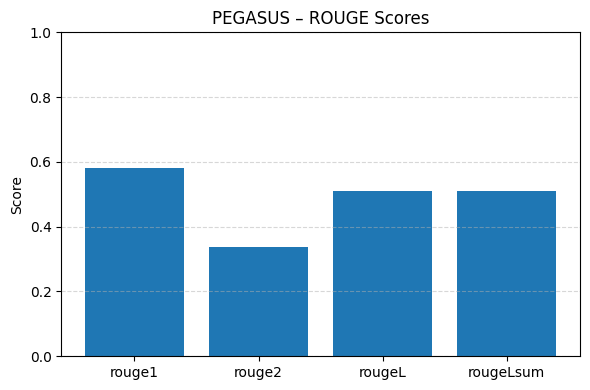

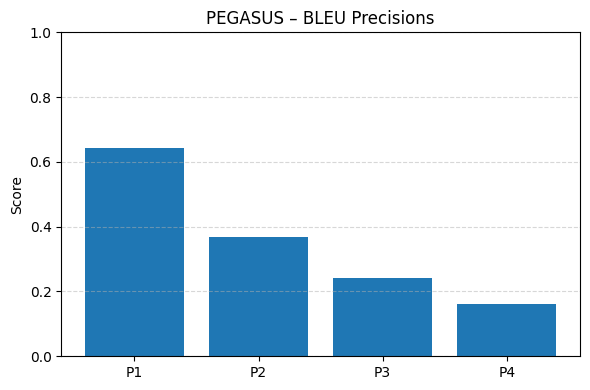

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import PegasusForConditionalGeneration, PegasusTokenizerFast
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import evaluate as evaluate_hf
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PegasusForConditionalGeneration.from_pretrained('pegasus_paraphrase').to(device)
tokenizer = PegasusTokenizerFast.from_pretrained('pegasus_paraphrase')

df = pd.read_csv('paraphrased.csv').dropna()
texts = df['Text'].tolist()
refs  = df['Paraphrase'].tolist()

_, val_texts, _, val_refs = train_test_split(
    texts, refs, test_size=0.1, random_state=42
)
val_texts = val_texts[:300]
val_refs  = val_refs[:300]

class ParaphraseDataset(Dataset):
    def __init__(self, srcs, tgts, tokenizer, max_len=128):
        self.srcs = srcs
        self.tgts = tgts
        self.tok  = tokenizer
        self.max = max_len

    def __len__(self):
        return len(self.srcs)

    def __getitem__(self, i):
        inp = self.tok(self.srcs[i], max_length=self.max,
                       truncation=True, padding='max_length', return_tensors='pt')
        lbl = self.tok(self.tgts[i], max_length=self.max,
                       truncation=True, padding='max_length', return_tensors='pt')
        return {
            'input_ids':      inp['input_ids'].squeeze(),
            'attention_mask': inp['attention_mask'].squeeze(),
            'labels':         lbl['input_ids'].squeeze()
        }

val_ds     = ParaphraseDataset(val_texts, val_refs, tokenizer, max_len=128)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

rouge = evaluate_hf.load("rouge")
bleu  = evaluate_hf.load("bleu")

model.eval()
preds, targets = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Évaluation Pegasus", dynamic_ncols=True):
        ids   = batch['input_ids'].to(device)
        mask  = batch['attention_mask'].to(device)
        outs  = model.generate(ids,
                               attention_mask=mask,
                               max_length=128,
                               num_beams=4,
                               early_stopping=True)
        dec_preds = tokenizer.batch_decode(outs, skip_special_tokens=True)
        dec_refs  = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
        preds.extend(dec_preds)
        targets.extend(dec_refs)

rouge_res = rouge.compute(predictions=preds,
                          references=targets,
                          use_stemmer=True)
bleu_res  = bleu.compute(predictions=preds,
                         references=[[r] for r in targets])

rouge_df = pd.DataFrame.from_dict(rouge_res, orient='index', columns=['Score']).round(4)
bleu_df  = pd.DataFrame({
    'Metric': ['BLEU', 'P1', 'P2', 'P3', 'P4', 'BP', 'LR', 'TL', 'RL'],
    'Value': [
        round(bleu_res['bleu'],4),
        round(bleu_res['precisions'][0],4),
        round(bleu_res['precisions'][1],4),
        round(bleu_res['precisions'][2],4),
        round(bleu_res['precisions'][3],4),
        round(bleu_res['brevity_penalty'],4),
        round(bleu_res['length_ratio'],4),
        bleu_res['translation_length'],
        bleu_res['reference_length'],
    ]
})

print("\n=== PEGASUS – ROUGE Scores ===")
print(rouge_df)
print("\n=== PEGASUS – BLEU Scores ===")
print(bleu_df.set_index('Metric'))


plt.figure(figsize=(6,4))
plt.bar(rouge_df.index, rouge_df['Score'])
plt.ylim(0,1)
plt.title('PEGASUS – ROUGE Scores')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('pegasus_rouge.png')
plt.show()

plt.figure(figsize=(6,4))
prec = bleu_res['precisions']
plt.bar([f'P{i+1}' for i in range(4)], prec)
plt.ylim(0,1)
plt.title('PEGASUS – BLEU Precisions')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('pegasus_bleu_precisions.png')
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17200\3417499762.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rouge_df, x='Metric', y='Score', palette='Blues_d', ax=axes[0,0])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17200\3417499762.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bleu_df_prec, x='Precision', y='Score', palette='Greens_d', ax=axes[0,1])


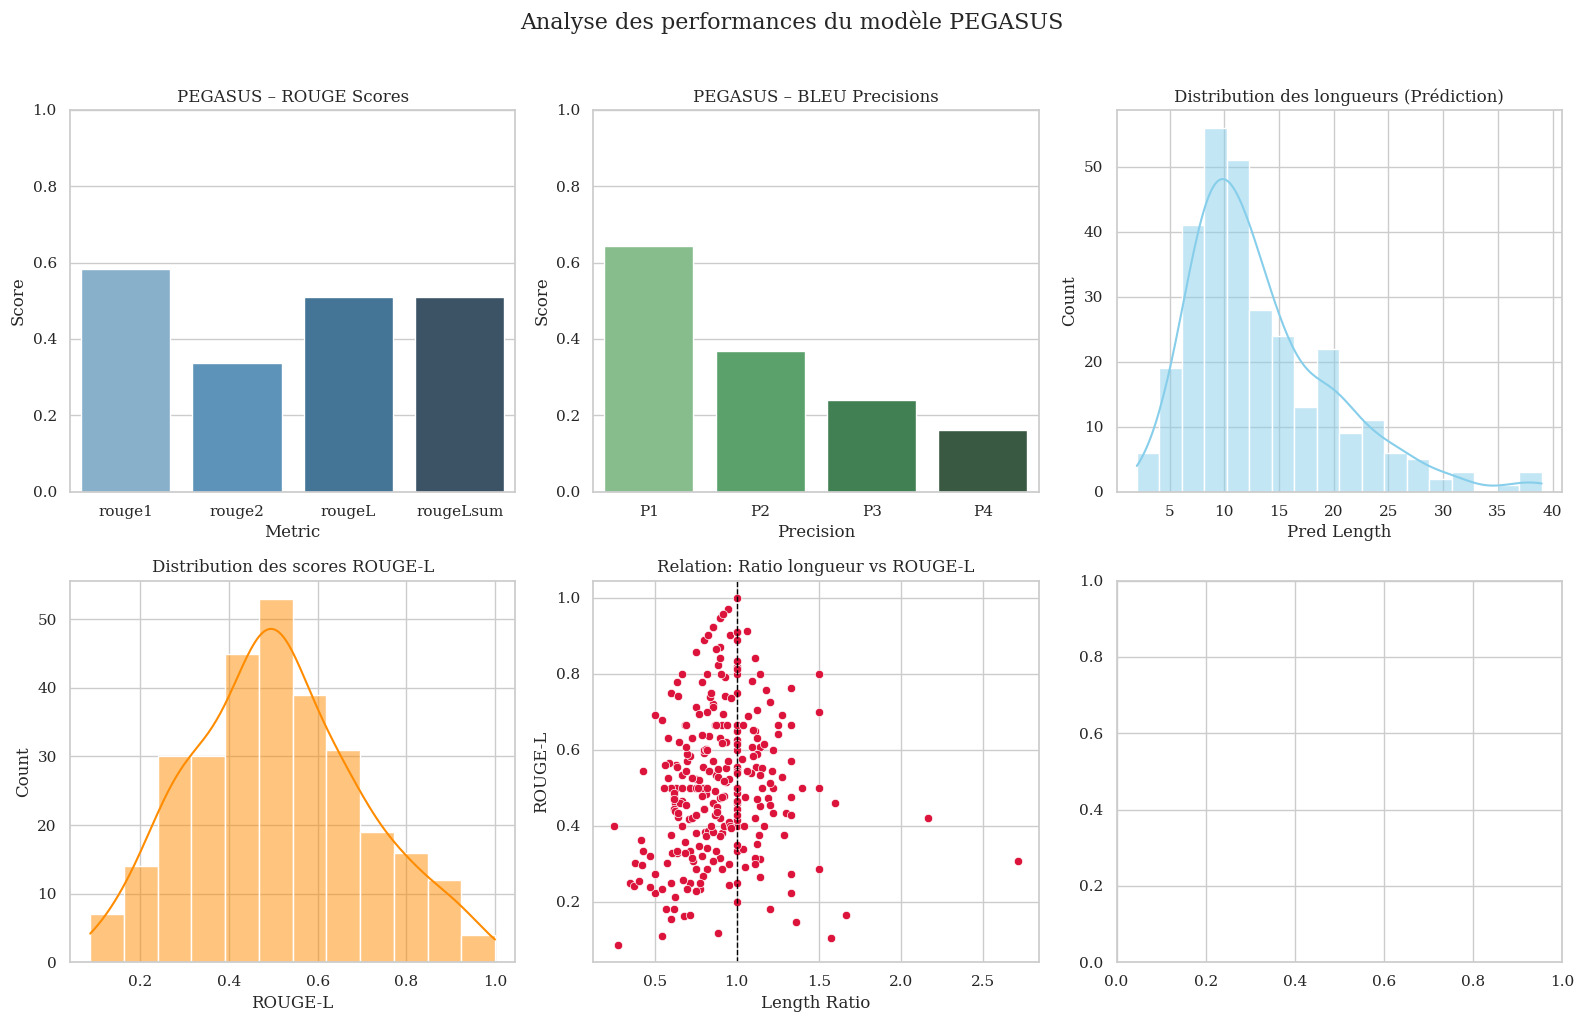

In [ ]:

results_df = pd.DataFrame({
    'Prediction':  preds,
    'Reference':   targets,
    'Pred Length': [len(p.split()) for p in preds],
    'Ref Length':  [len(r.split()) for r in targets]
})
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
results_df['ROUGE-L'] = [
    scorer.score(ref, pred)['rougeL'].fmeasure
    for ref, pred in zip(results_df['Reference'], results_df['Prediction'])
]
results_df['Length Ratio'] = results_df['Pred Length'] / results_df['Ref Length']
results_df['BLEU'] = bleu_res['bleu']  

rouge_df = pd.DataFrame.from_dict(rouge_res, orient='index', columns=['Score']).reset_index().rename(columns={'index':'Metric'})
bleu_df_prec = pd.DataFrame({
    'Precision': [f'P{i+1}' for i in range(4)],
    'Score': bleu_res['precisions']
})

sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (16, 10), 'font.family': 'serif'})

fig, axes = plt.subplots(2, 3)

sns.barplot(data=rouge_df, x='Metric', y='Score', palette='Blues_d', ax=axes[0,0])
axes[0,0].set_ylim(0,1)
axes[0,0].set_title('PEGASUS – ROUGE Scores')

sns.barplot(data=bleu_df_prec, x='Precision', y='Score', palette='Greens_d', ax=axes[0,1])
axes[0,1].set_ylim(0,1)
axes[0,1].set_title('PEGASUS – BLEU Precisions')

sns.histplot(results_df['Pred Length'], kde=True, color='skyblue', ax=axes[0,2])
axes[0,2].set_title('Distribution des longueurs (Prédiction)')

sns.histplot(results_df['ROUGE-L'], kde=True, color='darkorange', ax=axes[1,0])
axes[1,0].set_title('Distribution des scores ROUGE-L')

sns.scatterplot(data=results_df, x='Length Ratio', y='ROUGE-L', color='crimson', ax=axes[1,1])
axes[1,1].axvline(1.0, color='black', linestyle='--', linewidth=1)
axes[1,1].set_title('Relation: Ratio longueur vs ROUGE-L')

plt.tight_layout(rect=[0,0,1,0.96])
plt.suptitle("Analyse des performances du modèle PEGASUS", fontsize=16, y=1.02)
plt.savefig('pegasus_full_dashboard.png')
plt.show()